In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer, SimpleImputer
import lime.lime_tabular
from skimage.segmentation import mark_boundaries
from lime import lime_image
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from FuncAux import plot_PR, plot_ROC, compare_ROC, compare_PR, compute_metrics
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras as keras
import os
import sys
import random
import shutil

In [2]:
subfolders = [ f.path for f in os.scandir(".\\datasets\\brain_tumor_imgs") if f.is_dir() ]
classes_F = [x.split("\\")[-1] for x in subfolders ]
classes_F

['1', '2', '3']

In [3]:
# X = []
# y = []
# for class_X in classes_F:
#     dir = os.listdir(f".\\datasets\\brain_tumor_imgs\\{class_X}")
#     print(len(dir))
#     train_size = int(0.80 * len(dir))
#     train_samples = random.sample(dir, train_size)
#     for file in dir:
#         if file in train_samples:
#             shutil.copy(os.path.join(f".\\datasets\\brain_tumor_imgs\\{class_X}",file), os.path.join(f".\\datasets\\brain_tumor_imgsv2\\train\\{class_X}",file))
#         else:
#             shutil.copy(os.path.join(f".\\datasets\\brain_tumor_imgs\\{class_X}",file), os.path.join(f".\\datasets\\brain_tumor_imgsv2\\test\\{class_X}",file))
        # img = cv2.imread(os.path.join(f".\\datasets\\brain_tumor_imgs\\{class_X}",file))
        # if img is not None and img.shape == (512,512,3):
        #     X.append(np.array(img))
        #     y.append(int(class_X))

In [4]:
# np.unique(y, return_counts=True)

In [5]:
# X = np.array(X)
# y = np.array(y)

In [6]:
# len(X), sys.getsizeof(X), len(y), np.array(X).shape, np.array(y).shape

In [7]:
# np.array(X[0]).shape

In [8]:
# plt.imshow(cv2.cvtColor(X[0], cv2.COLOR_BGR2RGB))

In [9]:
# img_processed = cv2.resize(X[0], None, fx = 0.5, fy = 0.5)
# plt.imshow(cv2.cvtColor(img_processed, cv2.COLOR_BGR2RGB))

In [10]:
# y = [y.columns[x] for x in np.argmax(y, axis=1)]
# np.unique(y, return_counts=True)

In [11]:
# classes = np.unique(y, return_counts=True)
# classes

In [95]:
dbDir=".\\datasets\\brain_tumor_imgsv2\\"

ISize = (128, 128)
bSize = 20

dataGen=ImageDataGenerator(preprocessing_function=preprocess_input)

trainGen=dataGen.flow_from_directory(directory=dbDir+"train\\",
target_size=ISize, class_mode="categorical", shuffle=True, seed=42)

trainGen2=dataGen.flow_from_directory(directory=dbDir+"train\\",
target_size=ISize, class_mode="categorical", shuffle=True, seed=42)


testGen=dataGen.flow_from_directory(directory=dbDir+"test/",
target_size=ISize, class_mode="categorical", shuffle=True, seed=42)

Found 2450 images belonging to 3 classes.
Found 2450 images belonging to 3 classes.
Found 614 images belonging to 3 classes.


In [96]:
A, a = trainGen.__getitem__(0)
A2, a2 = trainGen2.__getitem__(0)

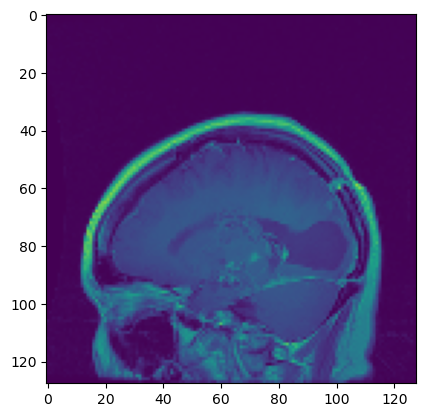

In [97]:
plt.imshow((A[0] + 1)/2)

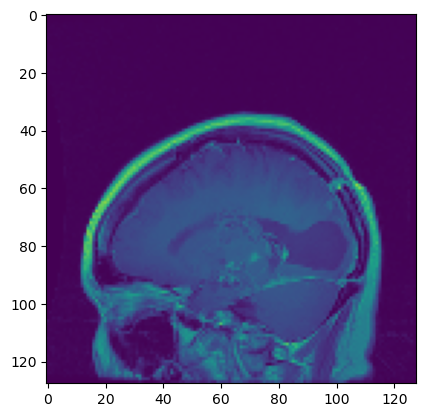

In [98]:
plt.imshow((A2[0] + 1)/2)

0


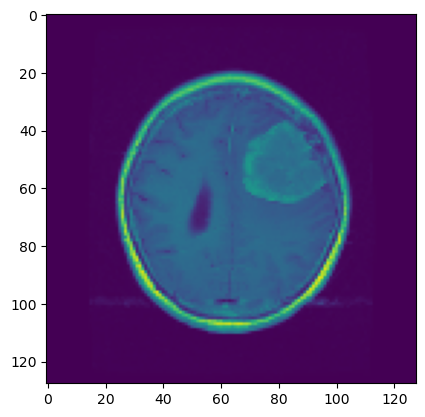

In [80]:
plt.imshow((A[0] + 1)/2)
print(f"Class: {np.argmax(a[0])}")

In [14]:
def class_dist(classes):
    fig, ax = plt.subplots(figsize=(14, 5))
    fig.suptitle('Distribuição das Classes')
    
    c1 = (169/255,209/255,142/255)
    c2 = (120/255, 182/255, 78/255)
    c3 = (84/255, 130/255, 53/255)
    
    ax.bar([str(x) for x in classes[0]], classes[1], color=c2)
    
    ax.bar_label(ax.containers[0], labels=classes[1], label_type='edge', fontsize=10)
    
# class_dist(classes)

In [15]:
# X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [16]:
# print(f"DImensões do treino:  {len(X_train)}")
# print(f"Dimensões do teste:  {len(X_test)}")

## Class distribution on the train split

In [41]:
from tensorflow.keras import models
from tensorflow.keras import layers

cnn_raw = models.Sequential()
cnn_raw.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(128,128,3)))
cnn_raw.add(layers.Conv2D(16, (3, 3), activation='relu'))
cnn_raw.add(layers.MaxPooling2D((2, 2)))
cnn_raw.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_raw.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_raw.add(layers.MaxPooling2D((2, 2)))
cnn_raw.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_raw.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_raw.add(layers.MaxPooling2D((2, 2)))
cnn_raw.add(layers.Flatten())
cnn_raw.add(layers.Dense(15, activation='relu'))
cnn_raw.add(keras.layers.Dropout(0.15))
cnn_raw.add(layers.Dense(3, activation='softmax'))

In [42]:
opt = keras.optimizers.Nadam(learning_rate=0.005, beta_1=0.9,
beta_2=0.99)

cnn_raw.compile(loss="categorical_crossentropy",
optimizer=opt, metrics=["accuracy"])

In [43]:
cnn_raw.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_49 (Conv2D)              │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 124, 124, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 60, 60, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 58, 58, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 29, 29, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 27, 27, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 15)             │       138,255 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │            48 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 210,383 (821.81 KB)

 Trainable params: 210,383 (821.81 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
history_multi1 = cnn_raw.fit(trainGen, epochs=10)

Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 56s 404ms/step - accuracy: 0.5297 - loss: 2.4665
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 34s 408ms/step - accuracy: 0.7219 - loss: 0.6324
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 34s 407ms/step - accuracy: 0.7699 - loss: 0.5375
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 34s 404ms/step - accuracy: 0.7719 - loss: 0.4849
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 33s 404ms/step - accuracy: 0.8214 - loss: 0.4034
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 33s 403ms/step - accuracy: 0.8168 - loss: 0.4122
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 34s 404ms/step - accuracy: 0.8286 - loss: 0.3804
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 33s 401ms/step - accuracy: 0.8480 - loss: 0.3655
Epoch 9/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 34s 405ms/step - accuracy: 0.8738 - loss: 0.3155
Epoch 10/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 33s 400ms/step - accuracy: 0.8642 - loss: 0.3071


(0.0, 10.0, 0.0, 1.0)

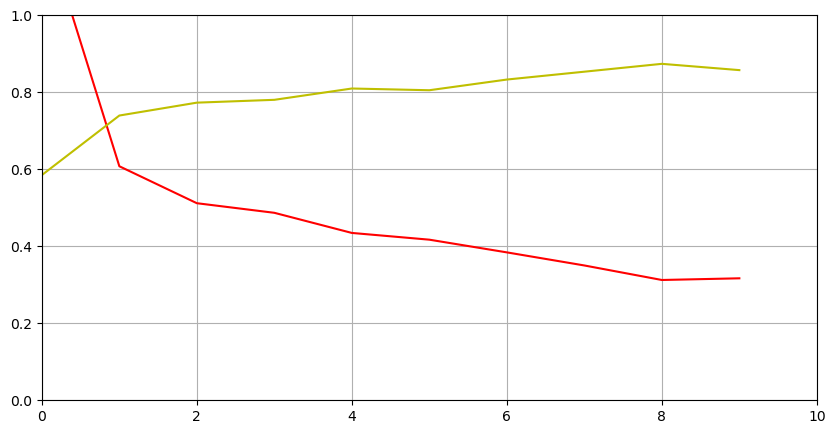

In [45]:
h=history_multi1.history
plt.figure(figsize=(10,5))
plt.plot(h['loss'], "r")
# plt.plot(h['val_loss'], "k")
plt.plot(h['accuracy'], "y")
# plt.plot(h['val_accuracy'], "b")
plt.grid(True)
plt.axis([0,10,0,1])

In [ ]:
y1_multi = np.array([])
ye1_multi = np.array([])
Ye1_multi_all = np.array([])
c = 0

for I, Y in testGen:
    y_multi = np.hstack((y1_multi, np.argmax(Y, axis=1)))
    Ye = cnn_raw.predict(I)
    ye_multi = np.hstack((ye1_multi, np.argmax(Ye, axis=1)))
    if c == 0:
        Ye_multi_all = Ye
    else:
        Ye_multi_all = np.vstack((Ye1_multi_all, Ye))
        
    print(I.shape, Y.shape, c)
    c += 1
    
    if c>=len(testGen):
        break

In [ ]:
cm1_multi = confusion_matrix(y1_multi, ye1_multi)
print(cm1_multi)
acc_aug_binc = round(cm1_multi.diagonal().sum()/cm1_multi.sum() * 100, 2)
print(f"Accuracy: {acc_aug_binc}%")

In [82]:
A, a = trainGen.__getitem__(0)

In [ ]:
img_index = 0
img_to_explain = (A[img_index] + 1) / 2
img_class = np.argmax(a[img_index])

  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━

TypeError: unhashable type: 'numpy.ndarray'

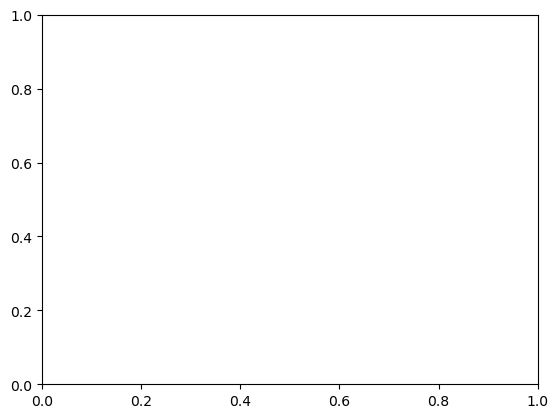

In [91]:
explainer = lime_image.LimeImageExplainer(random_state=42)
explanation = explainer.explain_instance(img_to_explain, 
                                         cnn_raw.predict, 
                                         top_labels=3, hide_color=0, num_samples=1000, 
                                         random_seed=42)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, hide_rest=True)

Text(0.5, 1.0, 'Mask')

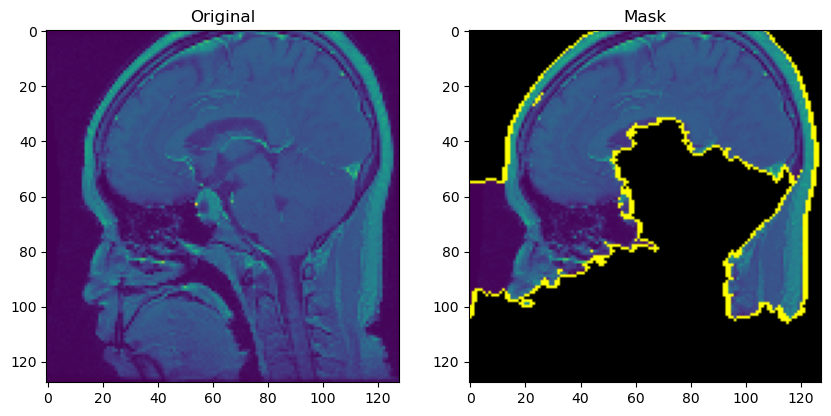

In [94]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow((A[3] + 1)/2)
plt.title("Original")

img_mask = mark_boundaries(temp, mask)
plt.subplot(1,2,2)
plt.imshow(img_mask)
plt.title("Mask")

In [22]:
cnn_trained = MobileNetV2(
    include_top=False,
    alpha=1.0)

cnn_trained.trainable=False

cnn2=keras.models.Sequential()
cnn2.add(cnn_trained)
cnn2.add(keras.layers.Flatten())
cnn2.add(keras.layers.Dense(15, activation='relu'))
cnn2.add(keras.layers.Dropout(0.15))
cnn2.add(keras.layers.Dense(3, activation='softmax'))

C:\Users\alexv.DESKTOP-H277D4D\AppData\Local\Temp\ipykernel_17760\2146353696.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  cnn_trained = MobileNetV2(


In [23]:
opt2 = keras.optimizers.Nadam(learning_rate=0.005, beta_1=0.9,
beta_2=0.99)

cnn2.compile(loss="categorical_crossentropy",
optimizer=opt2, metrics=["accuracy"])

In [24]:
cnn2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [113]:
# X_train.shape, Y_train.shape, np.unique(Y_train, return_counts=True)

((2042, 512, 512, 3),
 (2042,),
 (array([1, 2, 3]), array([458, 971, 613], dtype=int64)))

In [114]:
# Y_train_one_hot = keras.utils.to_categorical(Y_train-1, num_classes=3)

In [25]:
history_multi2 = cnn2.fit(trainGen, steps_per_epoch=len(trainGen), epochs=10)

Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 85s 991ms/step - accuracy: 0.5338 - loss: 9.0819
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 78s 974ms/step - accuracy: 0.5967 - loss: 0.8517
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 117us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 78s 975ms/step - accuracy: 0.7035 - loss: 0.6896
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 104us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 79s 992ms/step - accuracy: 0.7061 - loss: 0.5553
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 117us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 78s 975ms/step - accuracy: 0.7277 - loss: 0.5731
Epoch 10/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 104us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00


In [59]:
#history_bin1 = cnn_raw.fit(X_train, Y_train_one_hot, epochs=7, steps_per_epoch=30, batch_size=int(len(Y_train)/210))

Epoch 1/7
30/30 ━━━━━━━━━━━━━━━━━━━━ 33s 923ms/step - accuracy: 0.3935 - loss: 2.0036
Epoch 2/7
30/30 ━━━━━━━━━━━━━━━━━━━━ 28s 920ms/step - accuracy: 0.5215 - loss: 1.0729
Epoch 3/7
30/30 ━━━━━━━━━━━━━━━━━━━━ 28s 926ms/step - accuracy: 0.4566 - loss: 1.0677
Epoch 4/7
30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 960ms/step - accuracy: 0.4784 - loss: 1.0601
Epoch 5/7
30/30 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.4288 - loss: 1.0782
Epoch 6/7
26/30 ━━━━━━━━━━━━━━━━━━━━ 3s 988ms/step - accuracy: 0.4317 - loss: 1.0709

KeyboardInterrupt: 

(0.0, 5.0, 0.0, 1.0)

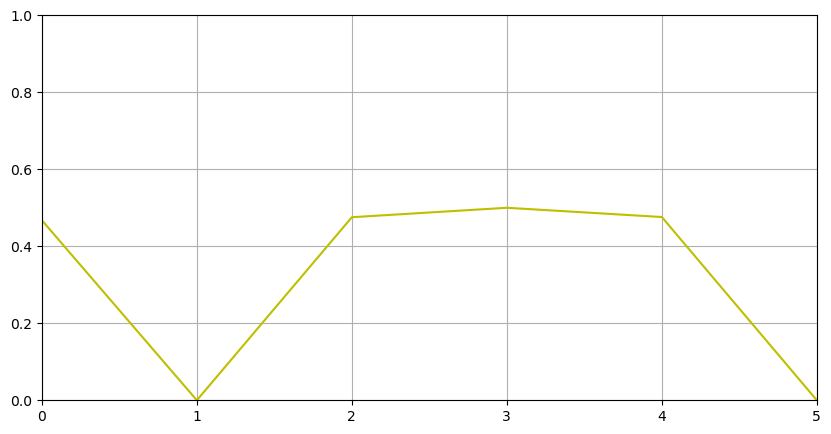

In [27]:
h=history_multi2.history
plt.figure(figsize=(10,5))
plt.plot(h['loss'], "r")
# plt.plot(h['val_loss'], "k")
plt.plot(h['accuracy'], "y")
# plt.plot(h['val_accuracy'], "b")
plt.grid(True)
plt.axis([0,10,0,1])

-1

In [ ]:
y_multi = np.array([])
ye_multi = np.array([])
Ye_multi_all = np.array([])
c = 0

for I, Y in testGen:
    y_multi = np.hstack((y_multi, np.argmax(Y, axis=1)))
    Ye = cnn2.predict(I)
    ye_multi = np.hstack((ye_multi, np.argmax(Ye, axis=1)))
    if c == 0:
        Ye_multi_all = Ye
    else:
        Ye_multi_all = np.vstack((Ye_multi_all, Ye))
        
    print(I.shape, Y.shape, c)
    c += 1
    
    if c>=len(testGen):
        break

In [41]:
explainer = lime_image.LimeImageExplainer(random_state=42)
explanation = explainer.explain_instance(X_train[2], 
                                             cnn_raw.predict, 
                                             top_labels=3, hide_color=0, num_samples=1000, 
                                             random_seed=42)


temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, 
                                                    num_features=5, hide_rest=False)
cv2.imshow("Porreiro", mark_boundaries(temp, mask))
cv2.waitKey(0)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

-1